### Goal: Determine the function that creates the 'rating' value on HLTV

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os import listdir
from os.path import join

import matplotlib.style as style
style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Player Level Analysis

In [2]:
path = '../data/master_players'
files = listdir(path)

# Import data
player_df = pd.DataFrame()
for file in files:
    file_df = pd.read_csv(os.path.join(path, file))
    player_df = player_df.append(file_df, ignore_index=True, sort=False)
    
# Convert unix time stamp to date time
player_df['date'] = player_df['date'] / 1000
player_df['date'] = pd.to_datetime(player_df['date'], unit ='s')

# Keep only date
player_df['date'] = player_df['date'].dt.date

# Drop rows with NaN in KAST or ADR
player_df = player_df.loc[-player_df['KAST'].isna(), :]
player_df = player_df.loc[-player_df['ADR'].isna(), :]
player_df.reset_index(drop=True, inplace=True)
    
print(player_df.shape)
player_df.tail()

(534167, 20)


,map_id,map,date,team_id,team_name,player_id,player_name,kills,hs_kills,assists,flash_assists,deaths,KAST,kill_death_diff,ADR,first_kills_diff,rating,kills_per_round,deaths_per_round,impact
534162,59509,mrg,2017-12-31,7354,MVP PK,4637,zeff,15,9,10,4,30,67.6,-15,56.8,0,0.70,0.44,0.88,0.58
534163,59511,ovp,2017-12-31,7354,MVP PK,174,solo,8,4,4,2,17,52.2,-9,61.6,-1,0.53,0.35,0.74,0.10
534164,71584,cch,2017-09-08,8242,ARES,9644,YOUYOU,12,4,1,0,7,93.8,5,67.1,1,1.24,0.75,0.44,0.70
534165,71585,cbl,2017-09-08,8242,ARES,9644,YOUYOU,13,7,1,0,5,81.2,8,63.7,-2,1.36,0.81,0.31,0.86
534166,72293,cch,2017-08-26,8316,Most Wanted,14204,jet-,18,9,1,0,19,70.0,-1,62.6,3,0.98,0.60,0.63,0.78


In [21]:
# Get features that could help determine the rating feature
keeper_columns = ['kills', 'hs_kills', 'assists', 'flash_assists', 'deaths', 'KAST', 'kill_death_diff', 
                  'ADR', 'first_kills_diff', 'kills_per_round', 'deaths_per_round', 'impact', 'rating']
player_df = player_df[keeper_columns]
player_df.drop_duplicates(inplace=True)
player_df.dropna(inplace=True)
player_df.reset_index(inplace=True, drop=True)

print(player_df.shape)

(534134, 13)


#### Model Creation

In [22]:
idx = np.random.randint(0, len(player_df), size=len(player_df))
train_idx, test_idx = idx[:400000], idx[400000:]
train_x = player_df.loc[train_idx,:].drop(columns=['rating'])
train_y = player_df.loc[train_idx, 'rating']
test_x = player_df.loc[test_idx,:].drop(columns=['rating'])
test_y = player_df.loc[test_idx, 'rating']

In [ ]:
# Linear Regression
from sklearn.linear_model import LinearRegression

reg = LinearRegression(normalize=True)

# Train
reg.fit(train_x, train_y)

# Evaluate (R^2)
print(reg.score(test_x, test_y))

# Coefficients
reg.coef_

In [30]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(n_estimators=100, verbose=True, n_jobs=-1)

# Train
reg.fit(train_x, train_y)

# Evaluate (R^2)
print(reg.score(test_x, test_y))

# Coefficients
reg.feature_importances_

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   57.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s


0.9958655603581265


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.9s finished


array([2.78950616e-02, 7.05894850e-04, 6.32876714e-04, 2.70836523e-04,
       7.25789050e-03, 3.42726775e-02, 7.16606125e-01, 2.21301247e-02,
       8.29266350e-04, 1.46177575e-01, 5.57623521e-03, 3.76454361e-02])

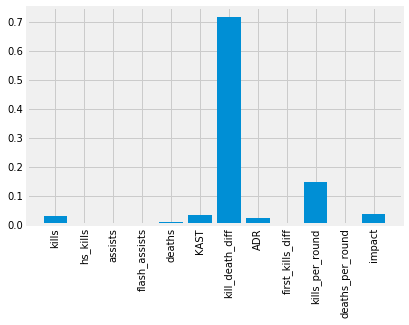

In [35]:
plt.bar(train_x.columns, reg.feature_importances_)
plt.xticks(rotation='vertical')
plt.show()

In [39]:
# Dense Neural Network
from sklearn.neural_network import MLPRegressor

reg = MLPRegressor(hidden_layer_sizes=(3,3,3), early_stopping=True)

# Train
reg.fit(train_x, train_y)

# Evaluate (R^2)
print(reg.score(test_x, test_y))

0.9927992139074734


So kill death difference and kills per round are the most significant variables to a players 'rating'. When finding the top players, maybe look at these metrics or just rating directly for fantasy league.

### ESL ONE COLOGNE - RANKING PLAYERS

So just as a review, we are looking at players weighted average kills, assists, deaths, and ADR from the past year. This was determined by exponentially decaying on their performanes. Essentially giving more weight to recent games than older games. From these features, I hope to be able to rank players reasonably well and also optimize against the fantasy leagues constraints (max: 1,000,000 USD team composition, player values [ex: 'Stewie2K' = 202,000 USD])

### Considerations only data where teams have played each other

In [40]:
path = '../data/master_players'
files = listdir(path)

# Import data
player_df = pd.DataFrame()
for file in files:
    file_df = pd.read_csv(os.path.join(path, file))
    player_df = player_df.append(file_df, ignore_index=True, sort=False)
    
# Convert unix time stamp to date time
player_df['date'] = player_df['date'] / 1000
player_df['date'] = pd.to_datetime(player_df['date'], unit ='s')
    
# Consider historical from 2018 to present
player_df = player_df.loc[player_df['date'] >= '2018-01-01 00:00:00', :]

# Keep only date
player_df['date'] = player_df['date'].dt.date

# Drop rows with NaN in KAST or ADR
player_df = player_df.loc[-player_df['KAST'].isna(), :]
player_df = player_df.loc[-player_df['ADR'].isna(), :]
player_df.reset_index(drop=True, inplace=True)
    
print(player_df.shape)
player_df.tail()

(256090, 20)


,map_id,map,date,team_id,team_name,player_id,player_name,kills,hs_kills,assists,flash_assists,deaths,KAST,kill_death_diff,ADR,first_kills_diff,rating,kills_per_round,deaths_per_round,impact
256085,79917,inf,2018-12-30,6503,CyberZen,180,Savage,12,8,5,0,17,77.3,-5,73.5,-3,0.98,0.55,0.77,0.66
256086,79918,mrg,2018-12-30,6503,CyberZen,839,tb,14,7,3,1,16,65.4,-2,65.7,-2,0.88,0.54,0.62,0.59
256087,79919,d2,2018-12-30,6503,CyberZen,839,tb,8,3,4,1,11,85.7,-3,43.3,-3,0.82,0.38,0.52,0.28
256088,79920,inf,2018-12-30,6503,CyberZen,7016,HZ,14,7,3,0,18,64.3,-4,50.9,-2,0.78,0.50,0.64,0.66
256089,79921,mrg,2018-12-30,6503,CyberZen,10168,bottle,10,5,4,1,9,77.8,1,59.7,1,1.13,0.56,0.50,0.92


In [41]:
# Subset dataframe by maps where only the teams in the tournament have played each other
team_names = ['Liquid', 'Astralis', 'ENCE', 'Vitality', 'NRG', 'FaZe', 'FURIA', 'MIBR',
              'fnatic', 'mousesports', 'Natus Vincere', 'NiP', 'Renegades', 'Heroic', 'BIG', 'MVP PK']

# Only data from the teams of interest
player_df = player_df.loc[player_df['team_name'].isin(team_names),:]

# Find map_ids that are shared between teams
shared_ids = []
all_ids = []
for team in team_names:
    team_df = player_df.loc[player_df['team_name'] == team, :]
    map_ids = list(team_df['map_id'].unique())

    # Check if map_id has already been collected
    for map_id in map_ids:
        if map_id in all_ids:
            shared_ids.append(map_id)
            
    all_ids = all_ids + list(map_ids)
    
print('Number of matches between all teams:', len(shared_ids))

# Collect only matches between teams in the tourny
player_df = player_df.loc[player_df['map_id'].isin(shared_ids),:]
player_df.head()

Number of matches between all teams: 994


,map_id,map,date,team_id,team_name,player_id,player_name,kills,hs_kills,assists,flash_assists,deaths,KAST,kill_death_diff,ADR,first_kills_diff,rating,kills_per_round,deaths_per_round,impact
342,80308,cch,2019-01-20,5973,Liquid,8738,EliGE,29,14,7,0,10,90.9,19,133.4,1,2.07,1.32,0.45,2.20
346,80313,mrg,2019-01-20,5973,Liquid,8520,NAF,30,10,3,2,22,72.2,8,89.2,0,1.24,0.83,0.61,1.15
349,80317,d2,2019-01-20,5973,Liquid,8738,EliGE,28,13,6,2,14,84.0,14,108.7,3,1.79,1.12,0.56,2.06
355,80323,inf,2019-01-21,5973,Liquid,8520,NAF,15,8,4,1,17,90.0,-2,85.4,2,1.07,0.75,0.85,0.71
356,80324,d2,2019-01-21,5973,Liquid,8797,Stewie2K,27,8,3,0,16,74.1,11,111.2,3,1.55,1.00,0.59,1.51


In [42]:
# Number of days from today
current_datetime = pd.Timestamp('today').date()
player_df['days_from_today'] = (current_datetime - player_df['date']) / np.timedelta64(1, 'D')

# Exponential Decay from today
def exp_decay(days, a=1, r=0.03):
    '''
    @days: days from today
    @a: initial value
    @r: decay rate
    '''
    return a * (1 - r) ** days

player_df['decay'] = player_df['days_from_today'].apply(exp_decay)

# Normalize decay on a per player basis
player_df['normalized_decay'] = player_df['decay'] / player_df.groupby('player_id')['decay'].transform('sum')

player_df.head()

,map_id,map,date,team_id,team_name,player_id,player_name,kills,hs_kills,assists,flash_assists,deaths,KAST,kill_death_diff,ADR,first_kills_diff,rating,kills_per_round,deaths_per_round,impact,days_from_today,decay,normalized_decay
342,80308,cch,2019-01-20,5973,Liquid,8738,EliGE,29,14,7,0,10,90.9,19,133.4,1,2.07,1.32,0.45,2.20,166.0,0.006370,0.000432
346,80313,mrg,2019-01-20,5973,Liquid,8520,NAF,30,10,3,2,22,72.2,8,89.2,0,1.24,0.83,0.61,1.15,166.0,0.006370,0.000432
349,80317,d2,2019-01-20,5973,Liquid,8738,EliGE,28,13,6,2,14,84.0,14,108.7,3,1.79,1.12,0.56,2.06,166.0,0.006370,0.000432
355,80323,inf,2019-01-21,5973,Liquid,8520,NAF,15,8,4,1,17,90.0,-2,85.4,2,1.07,0.75,0.85,0.71,165.0,0.006567,0.000446
356,80324,d2,2019-01-21,5973,Liquid,8797,Stewie2K,27,8,3,0,16,74.1,11,111.2,3,1.55,1.00,0.59,1.51,165.0,0.006567,0.000446


In [43]:
# Aggregation on features with exponential decay to get current state of player
def player_features_normalized(stuff):
    new_df = pd.DataFrame()
    new_df['map_id'] = stuff['map_id']
    new_df['map'] = stuff['map']
    new_df['team_id'] = stuff['team_id']
    new_df['team_name'] = stuff['team_name']
    new_df['player_id'] = stuff['player_id']
    new_df['player_name'] = stuff['player_name']
    
    
    # Normalize features of interest
    columns = ['kills', 'assists', 'deaths', 'ADR', 'kill_death_diff', 'kills_per_round', 'rating']
    for column in columns:
        new_df[column] = stuff[column] * stuff['normalized_decay']
    
    return new_df

player_norm_df = player_features_normalized(player_df)
player_norm_df.head()

,map_id,map,team_id,team_name,player_id,player_name,kills,assists,deaths,ADR,kill_death_diff,kills_per_round,rating
342,80308,cch,5973,Liquid,8738,EliGE,0.012541,0.003027,0.004324,0.057688,0.008216,0.000571,0.000895
346,80313,mrg,5973,Liquid,8520,NAF,0.012973,0.001297,0.009514,0.038574,0.003460,0.000359,0.000536
349,80317,d2,5973,Liquid,8738,EliGE,0.012108,0.002595,0.006054,0.047007,0.006054,0.000484,0.000774
355,80323,inf,5973,Liquid,8520,NAF,0.006687,0.001783,0.007579,0.038073,-0.000892,0.000334,0.000477
356,80324,d2,5973,Liquid,8797,Stewie2K,0.012044,0.001338,0.007137,0.049602,0.004907,0.000446,0.000691


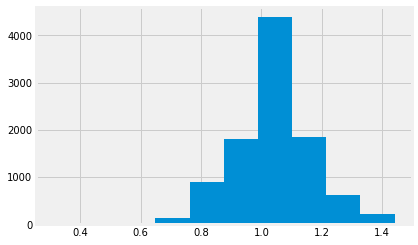

In [45]:
# Create 'true' features counts (sum up a feature)
player_norm_df['true_kills'] = player_norm_df.groupby('player_id')['kills'].transform('sum')
player_norm_df['true_assists'] = player_norm_df.groupby('player_id')['assists'].transform('sum')
player_norm_df['true_deaths'] = player_norm_df.groupby('player_id')['deaths'].transform('sum')
player_norm_df['true_ADR'] = player_norm_df.groupby('player_id')['ADR'].transform('sum')
player_norm_df['true_kill_death_diff'] = player_norm_df.groupby('player_id')['kill_death_diff'].transform('sum')
player_norm_df['true_kills_per_round'] = player_norm_df.groupby('player_id')['kills_per_round'].transform('sum')
player_norm_df['true_rating'] = player_norm_df.groupby('player_id')['rating'].transform('sum')

player_norm_df['true_rating'].hist()
plt.show()

In [46]:
# Collect only the player and their 'true' features
true_player_df = player_norm_df.drop(columns=['map_id', 'map', 'kills', 'assists', 'deaths', 
                                              'ADR', 'kill_death_diff', 'kills_per_round', 'rating']).drop_duplicates()
print(true_player_df.shape)
true_player_df.head()

(129, 11)


,team_id,team_name,player_id,player_name,true_kills,true_assists,true_deaths,true_ADR,true_kill_death_diff,true_kills_per_round,true_rating
342,5973,Liquid,8738,EliGE,21.989563,4.301092,17.507414,86.781680,4.482149,0.822845,1.263348
346,5973,Liquid,8520,NAF,17.866254,5.978353,17.009081,78.820851,0.857173,0.671193,1.124865
356,5973,Liquid,8797,Stewie2K,17.704708,4.519339,17.624957,72.691464,0.079751,0.658598,1.065740
486,6673,NRG,10671,Ethan,18.592145,5.722450,18.563796,80.251306,0.028350,0.690087,1.107792
488,6673,NRG,9136,Brehze,20.858208,3.616367,18.166247,80.066839,2.691962,0.763670,1.148113


In [50]:
# Rank by rating
true_player_df.sort_values(['true_rating'], ascending=False).reset_index(drop=True)

,team_id,team_name,player_id,player_name,true_kills,true_assists,true_deaths,true_ADR,true_kill_death_diff,true_kills_per_round,true_rating
0,9565,Vitality,11893,ZywOo,23.868804,6.002576,15.906888,92.716211,7.961916,0.902419,1.440952
1,4608,Natus Vincere,7998,s1mple,22.592957,3.707842,14.834001,88.851319,7.758957,0.890691,1.379600
2,6665,Astralis,7592,device,21.026647,3.993658,16.249338,87.648427,4.777309,0.817546,1.290623
3,5973,Liquid,8738,EliGE,21.989563,4.301092,17.507414,86.781680,4.482149,0.822845,1.263348
4,4608,Natus Vincere,8918,electronic,19.008989,4.782219,15.286315,84.627240,3.722674,0.755846,1.244870
5,4494,mousesports,8574,woxic,21.214666,5.088696,16.136656,82.622127,5.078009,0.771050,1.221218
6,6665,Astralis,9032,Magisk,18.297623,4.624208,15.659036,80.450380,2.638588,0.704985,1.188858
7,4494,mousesports,2730,chrisJ,20.505434,4.065326,17.569441,81.612372,2.935993,0.761247,1.184797
8,4869,ENCE,11916,sergej,21.039834,3.967165,17.980076,83.732345,3.059758,0.761181,1.171543
9,4494,mousesports,11816,ropz,18.621733,3.984199,14.960267,73.994341,3.661465,0.712867,1.163840


In [47]:
# Rank by kill death difference
true_player_df.sort_values(['true_kill_death_diff'], ascending=False).reset_index(drop=True)

,team_id,team_name,player_id,player_name,true_kills,true_assists,true_deaths,true_ADR,true_kill_death_diff,true_kills_per_round,true_rating
0,9565,Vitality,11893,ZywOo,23.868804,6.002576,15.906888,92.716211,7.961916,0.902419,1.440952
1,4608,Natus Vincere,7998,s1mple,22.592957,3.707842,14.834001,88.851319,7.758957,0.890691,1.379600
2,4494,mousesports,8574,woxic,21.214666,5.088696,16.136656,82.622127,5.078009,0.771050,1.221218
3,6665,Astralis,7592,device,21.026647,3.993658,16.249338,87.648427,4.777309,0.817546,1.290623
4,5973,Liquid,8738,EliGE,21.989563,4.301092,17.507414,86.781680,4.482149,0.822845,1.263348
5,4608,Natus Vincere,8918,electronic,19.008989,4.782219,15.286315,84.627240,3.722674,0.755846,1.244870
6,4494,mousesports,11816,ropz,18.621733,3.984199,14.960267,73.994341,3.661465,0.712867,1.163840
7,4869,ENCE,11916,sergej,21.039834,3.967165,17.980076,83.732345,3.059758,0.761181,1.171543
8,7175,Heroic,8783,JUGi,18.981990,3.091084,15.974425,74.528613,3.007565,0.750077,1.114265
9,4494,mousesports,2730,chrisJ,20.505434,4.065326,17.569441,81.612372,2.935993,0.761247,1.184797


In [48]:
# Rank by kills per round
true_player_df.sort_values(['true_kills_per_round'], ascending=False).reset_index(drop=True)

,team_id,team_name,player_id,player_name,true_kills,true_assists,true_deaths,true_ADR,true_kill_death_diff,true_kills_per_round,true_rating
0,9565,Vitality,11893,ZywOo,23.868804,6.002576,15.906888,92.716211,7.961916,0.902419,1.440952
1,4608,Natus Vincere,7998,s1mple,22.592957,3.707842,14.834001,88.851319,7.758957,0.890691,1.379600
2,5973,Liquid,8738,EliGE,21.989563,4.301092,17.507414,86.781680,4.482149,0.822845,1.263348
3,6665,Astralis,7592,device,21.026647,3.993658,16.249338,87.648427,4.777309,0.817546,1.290623
4,4494,mousesports,8574,woxic,21.214666,5.088696,16.136656,82.622127,5.078009,0.771050,1.221218
5,7532,BIG,7938,XANTARES,20.947599,3.897447,20.108596,84.506845,0.839003,0.770770,1.114679
6,6673,NRG,9136,Brehze,20.858208,3.616367,18.166247,80.066839,2.691962,0.763670,1.148113
7,4494,mousesports,2730,chrisJ,20.505434,4.065326,17.569441,81.612372,2.935993,0.761247,1.184797
8,4869,ENCE,11916,sergej,21.039834,3.967165,17.980076,83.732345,3.059758,0.761181,1.171543
9,4608,Natus Vincere,8918,electronic,19.008989,4.782219,15.286315,84.627240,3.722674,0.755846,1.244870


### ESL ONE COLOGNE Bracket

<div align="center"><img src="../images/ESL One Cologne-Group A.png" style="width:500px;height:300px"> <img src="../images/ESL One Cologne-Group B.png" style="width:500px;height:300px"></div>

<img src="../images/ESL One Cologne-Teams.png" class="center" style="width:600px;height:600px">

Top teams from each upper bracket advances to semi-finals. The losers of the upper bracket finals play in the quarterfinals. Top teams from each lower bracket advances to quarterfinals. Teams that lose in the first round player teams from the same side of their bracket in the lower bracket. Teams in the upper bracket that lose in the second round play on the opposite side of the lower bracket. All teams starting on a particular upper bracket will only play teams of the bracket until the playoffs (quarters/semis).

## Post Analysis

Fantasy system uses an average of a players pts when that player does not play during a particular round. This means that if your player bows out early, whatever their average pts was across the rounds that they played, gets added to your total score on each of the subsequent rounds. If one of your players advances and does not have to play a round (advances to the finals of the upper bracket and makes it directly to the semis), they also carry their average across those non-played rounds. **All in all, this means that you want to choose players that will make the semi's directly because you are more likely to be guaranteed points with less variation.**

I'll simulate the tournament next time to get the most likely outcomes for the tournament and prioritize players that are on teams that are likely to make the upper bracket finals and/or the semis. I will also take the final ratings of each player from the tourny to create a dataset to train on the final ratings given pre-match aggregate features.

I need to make sure to version my data.